In [125]:
#importing necessary libraries.
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks, medfilt
import pandas as pd
import numpy as np
import glob

In [126]:
# function for graphing.
def Graph(x,y):
    xlabel = x.name if hasattr(x, 'name') and x.name else "x"
    ylabel = y.name if hasattr(y, 'name') and y.name else "y"
    plt.plot(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs {xlabel}")
    plt.grid()
    plt.show()

In [127]:
# Loading the data from CSV files.
folder = "Datas/"
files = glob.glob(folder + "*.csv" )

# Reading and storing wavelength and intensity data.
Intensity = []
Wavelength = []
for file in files:
    data = pd.read_csv(file)
    Wavelength.append(data['wavelength'])
    Intensity.append(data['intensity'])

# Interpolating intensity data to a common master wavelength scale.
Interpolated_intensity = []
master_wavelength = pd.Series(Wavelength[0], name= 'Wavelength')
for w , i in zip(Wavelength, Intensity):
    interpolated_intensity = pd.Series(np.interp(master_wavelength, w, i), index=master_wavelength.index, name='Interpolated Intensity')
    Interpolated_intensity.append(interpolated_intensity)

# Calculating average intensity across all measurements.
matrix = np.vstack(Interpolated_intensity)
Avg_intensity = pd.Series(matrix.mean(axis = 0), index=master_wavelength.index, name='Average Intensity')

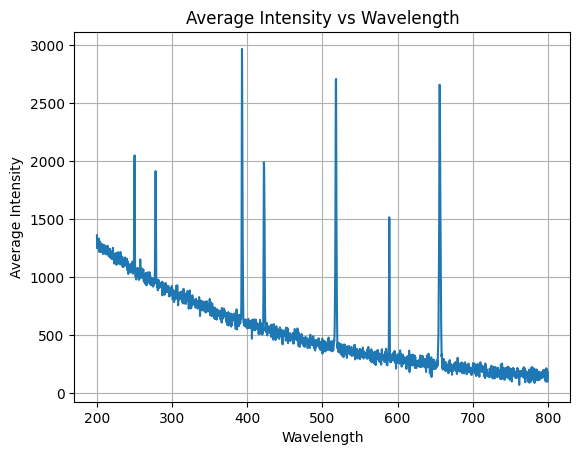

In [128]:
# Plotting the average intensity vs master wavelength.
Graph(master_wavelength, Avg_intensity)

In [129]:
#Smoothing the intensity by applying the savitzky-golay filter.
Smoothed_np = savgol_filter(Avg_intensity.values, window_length=51, polyorder=3)
Smoothed_intensity = pd.Series(Smoothed_np, index=master_wavelength.index, name='Smoothed Intensity')

# making a baseline correction using median filter.
baseline = medfilt(Smoothed_intensity, kernel_size = 101)
corrected = pd.Series((Smoothed_intensity-baseline),index = master_wavelength.index ,name = 'Corrected Intensity')
corrected[corrected< 0] = 0

# Finding peaks and its corresponding wavelength in the corrected data.
peak, s = find_peaks(corrected, height = 50, distance = 50)
peak_wavelength = master_wavelength.iloc[peak].reset_index(drop=True)

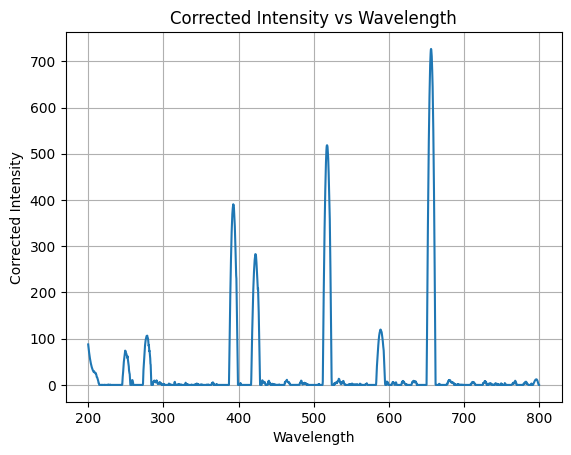

In [130]:
# Plotting the corrected intensity vs master wavelength.
Graph(master_wavelength, corrected)

In [ ]:
# Loading reference spectral lines and a tolerance range for element identification.
ref = pd.read_csv('specline.csv')
ref_wavelength = ref['wavelength']
ref_elements = ref['element']
ref_ion = ref['ion']
tolerance = 0.3

In [132]:
# Identifying elements corresponding to detected peaks.
for i in range(len(peak_wavelength)):
    differenc = abs(ref_wavelength - peak_wavelength[i])
    min_diff = differenc.min()
    closest = differenc.idxmin()

    if min_diff <= tolerance:
        element = ref.loc[closest, 'element']
        print("Detected element:", element,ref.loc[closest, 'ion'], "at wavelength:", peak_wavelength[i])
    else:
        print("No match for peak at:", peak_wavelength[i])

Detected element: Cl I at wavelength: 249.22461230615303
Detected element: Ar I at wavelength: 278.63931965982994
Detected element: Co II at wavelength: 392.99649824912456
Detected element: Co I at wavelength: 422.41120560280143
Detected element: S I at wavelength: 517.8589294647325
Detected element: Cu I at wavelength: 588.9944972486244
Detected element: Rb I at wavelength: 656.2281140570285
